In [1]:
#!pip install cellpose

Importing Necessary Libraries

In [69]:
import os
import numpy as np
import tifffile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

from cellpose import models
from skimage.measure import label
from skimage.color import label2rgb
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from cellpose.plot import image_to_rgb
from cellpose.utils import hsv_to_rgb, rgb_to_hsv, masks_to_outlines

from skimage.measure import regionprops_table, regionprops
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap

Using CellPose model for cell and nucleus segmentation ( https://www.nature.com/articles/s41592-020-01018-x  , https://github.com/MouseLand/cellpose)

In [3]:
cell_boundary_model = models.Cellpose( model_type='cyto2', gpu = True)
nucleus_model = models.Cellpose( model_type='cyto2', gpu = True)

In [4]:
# Folder containing input images and using pattern matching to effeciently import images according to the file naming conventions
image_folder = '/content/drive/MyDrive/JUMPTest/Images'
pattern = 'r{row:02d}c{col:02d}f{field:02d}p01-ch{channel}sk1fk1fl1.tiff'

# Directory to store any outputs produced in this notebook
output_dir = '/content/drive/MyDrive/ProcessedImages'
os.makedirs(output_dir, exist_ok=True)

# Using pattern to map to the input image path
def get_image_path(row, col, field, channel):

    return os.path.join(image_folder, pattern.format(row=row, col=col, field=field, channel=channel))

# Loading images in OpenCV
def load_images(rows, cols, fields, channels):
    img_list = []
    rows_1, cols_1, fields_1, channels_1, file_pattern = [],[],[],[],[]

    for row, col, field, channel in zip(rows, cols, fields, channels):
        img_path = get_image_path(row, col, field, channel)
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_list.append(img)

            rows_1.append(row)
            cols_1.append(col)
            fields_1.append(field)
            channels_1.append(channel)

            file_pattern.append(img_path)

    return img_list,rows_1,cols_1,fields_1,channels_1,file_pattern

# MAIN SEGMENTATION MODEL ( TAKES AN N DIMENSIONAL INPUT ARRAY OF IMAGES WHERE N IS NUMBER OF IMAGES )
def segment_images(image_array, model, diameter, channels):
    masks, flows, _ , _ = model.eval(image_array, diameter = diameter, channels= channels)

    return masks,flows

# COUNTING NO OF CELLS USING INSTANCE MASK
def count_cells(mask_array):

    return np.amax(mask_array, axis=(1, 2))

# A MODIFIED FUNCTION OF CELLPOSE API FOR PRODUCING VISUALIZATIONS (https://cellpose.readthedocs.io/en/latest/api.html#cellpose.plot.mask_overlay)
def mask_overlay(img, masks, colors=None):

    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = rgb_to_hsv(colors)
    if img.ndim>2:
        img = img.astype(np.float32).mean(axis=-1)
    else:
        img = img.astype(np.float32)
    
    HSV = np.zeros((img.shape[0], img.shape[1], 3), np.float32)
    HSV[:,:,2] = np.clip((img / 255. if img.max() > 1 else img) * 1.5, 0, 1)
    hues = np.linspace(0, 1, masks.max()+1)[np.random.permutation(masks.max())]
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = hues[n]
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = 1.0
    RGB = (hsv_to_rgb(HSV) * 255).astype(np.uint8)
    
    return RGB

# Takes both AGP Image and Nucleus Image and plots a graph containing 6 images. The image is stored to the path 
def save_segmentation_overlay(cyto_img, nuclie_img, cell_mask, nucleus_mask, store_path, file_name,channels=[0,0]):

    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(2,3,1)
    img0 = cyto_img.copy()
    img1 = nuclie_img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
        img1 = np.transpose(img1, (1,2,0))

    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = image_to_rgb(img0, channels=channels)
        img1 = image_to_rgb(img1, channels=channels)

    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
            img1 = np.uint8(np.clip(img1*255, 0, 1))

    ax.imshow(img0)
    ax.set_title('AGP Image')
    ax.axis('off')

    cell_outline = masks_to_outlines(cell_mask)
    nucleus_outline = masks_to_outlines(nucleus_mask)

    cell_overlay = mask_overlay(img0,cell_mask)
    nucleus_overlay = mask_overlay(img0,nucleus_mask)

    ax = fig.add_subplot(2,3,2)
    outX, outY = np.nonzero(cell_outline)
    imgout = img0.copy()
    imgout[outX, outY] = np.array([255,0,0])

    ax.imshow(imgout)
    ax.set_title('Cell Boundary - Outlines')
    ax.axis('off')

    ax = fig.add_subplot(2,3,3)
    ax.imshow(cell_overlay)
    ax.set_title('Cell Boundary - Instance Masks')
    ax.axis('off')

    ax = fig.add_subplot(2,3,4)
    outX, outY = np.nonzero(nucleus_outline)
    imgout_2 = img0.copy()
    imgout_2[outX, outY] = np.array([255,0,0])

    ax.imshow(imgout_2)
    ax.set_title('Nuclear Boundary - Outlines')
    ax.axis('off')

    ax = fig.add_subplot(2,3,5)
    ax.imshow(nucleus_overlay)
    ax.set_title('Nuclear Boundary - Instance Masks')
    ax.axis('off')

    ax = fig.add_subplot(2,3,6)
    ax.imshow(img1)
    ax.set_title('Nuclear Image')
    ax.axis('off')

    fig.suptitle('Segmentation Results for ' + file_name + ' -' + str(np.amax(cell_mask)) + ' Cells' )

    fig.savefig(os.path.join(store_path,file_name) + '.tiff') 
    plt.close(fig)

# WRAPPER over 'save_segmentation_overlay' to loop over all images
def save_highlighted_images(agp_array, nucleus_array, cell_boundary_masks, nucleus_masks, paths_in, output_subdir):
    output_path = os.path.join(output_dir, output_subdir)
    Path(output_path).mkdir(parents=True, exist_ok=True)

    for agp_img, nuclie_img, cell_boundary_mask, nucleus_mask, path_in in zip(agp_array, nucleus_array, cell_boundary_masks, nucleus_masks, paths_in):
        file_name = path_in.split('/')[-1].split('-')[0]
        save_segmentation_overlay(agp_img, nuclie_img, cell_boundary_mask, nucleus_mask, output_path, file_name, channels=[0,0])
      
# Plotting in notebook by taking n random samples from input sub directory. n(num_images)
def plot_highlighted_images(input_subdir, num_images):
    input_path = os.path.join(output_dir, input_subdir)
    files = sorted(os.listdir(input_path))

    files = random.sample(files, num_images)

    for file in files:
        img = cv2.imread(os.path.join(input_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20, 12))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [5]:
# Load AGP and nucleus images

#Creating a meshgrid for rows, cols and fields to process images and keep a track row numbeers, cols and fields.
rows, cols, fields = np.meshgrid(range(3, 15), range(8, 22), range(1, 10), indexing='ij')
rows, cols, fields = rows.flatten(), cols.flatten(), fields.flatten()
channels_agp = np.full_like(rows, 2)
channels_nucleus = np.full_like(rows, 5)

#Loading agp and nucleus images with its corresponding rows, cols, fields and channels
agp_imgs, agp_rows, agp_cols, agp_fields, agp_channels,agp_paths = load_images(rows, cols, fields, channels_agp)
nucleus_imgs, nuc_rows, nuc_cols, nuc_fields, nuc_channels,nuc_paths = load_images(rows, cols, fields, channels_nucleus)

# The nucleus channel is leveraged for cell segmentation in Cellpose. So, created a function to combine two channels
def combine_channels(list1, list2):
    array1, array2 = np.array(list1), np.array(list2)
    assert array1.shape == array2.shape
    combined_3d_image = np.stack((array1, array2), axis=-1)
    return combined_3d_image


agp_comb = combine_channels(agp_imgs,nucleus_imgs)

# RUNNING SEGMENTATION FOR BOTH CELLS AND NUCLEUS. OBTAINING INSTANCE SEGMENTATION MASKS FOR BOTH CELL AND NUCLEUS MODEL
cell_boundary_masks, cell_boundary_flows = segment_images(agp_comb, cell_boundary_model, 50, [1,2])
nucleus_masks, nucleus_flows = segment_images(nucleus_imgs, nucleus_model, 30, [0,0])

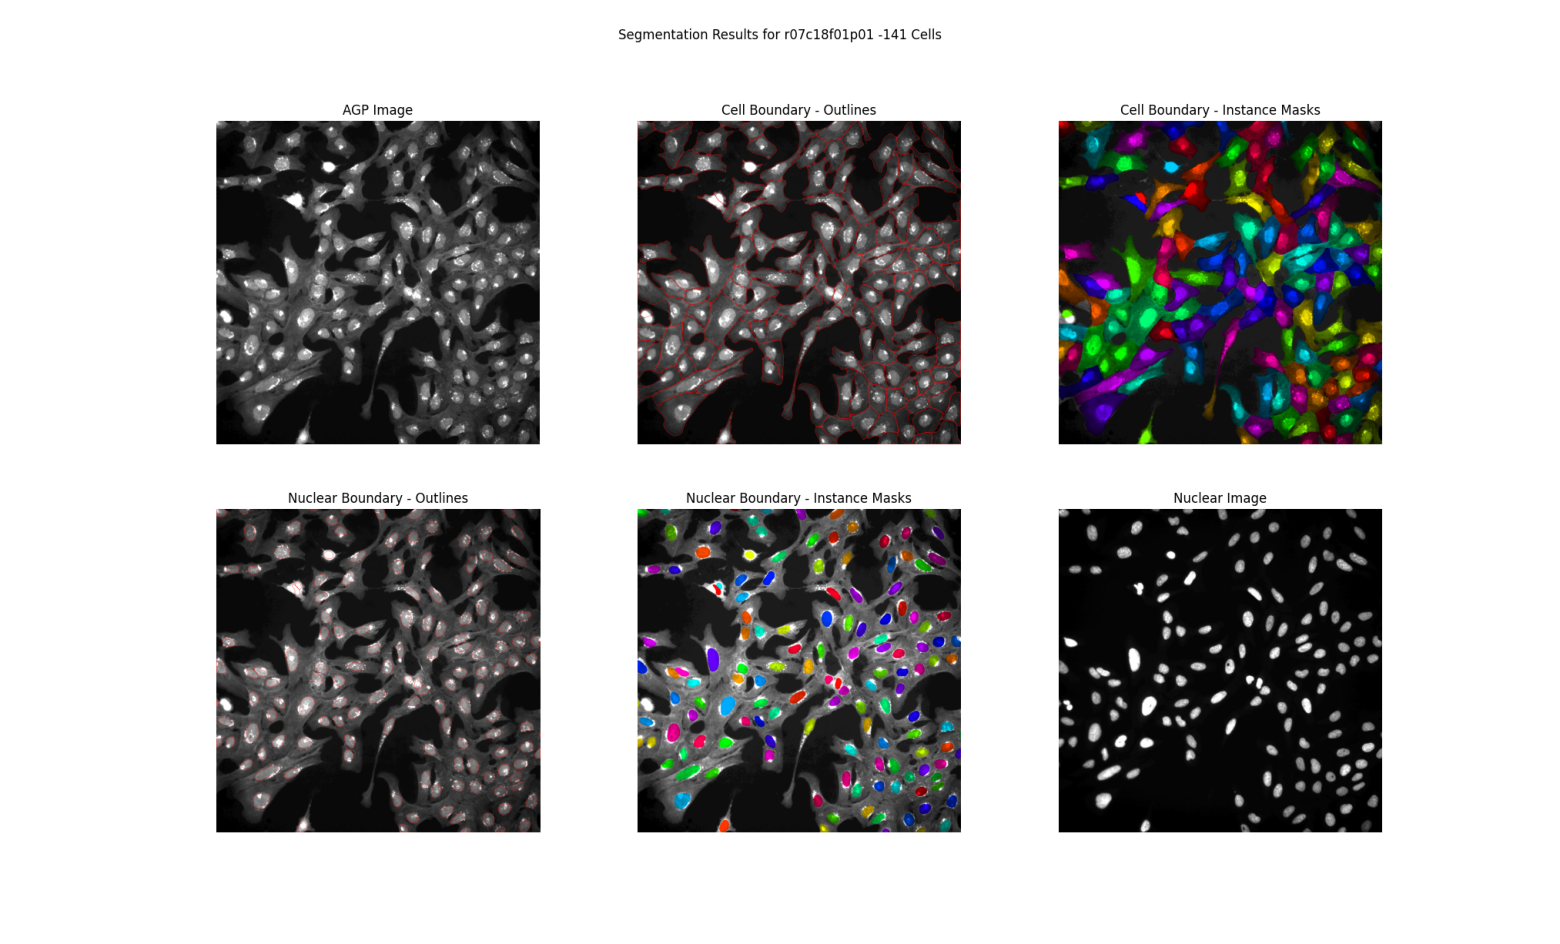

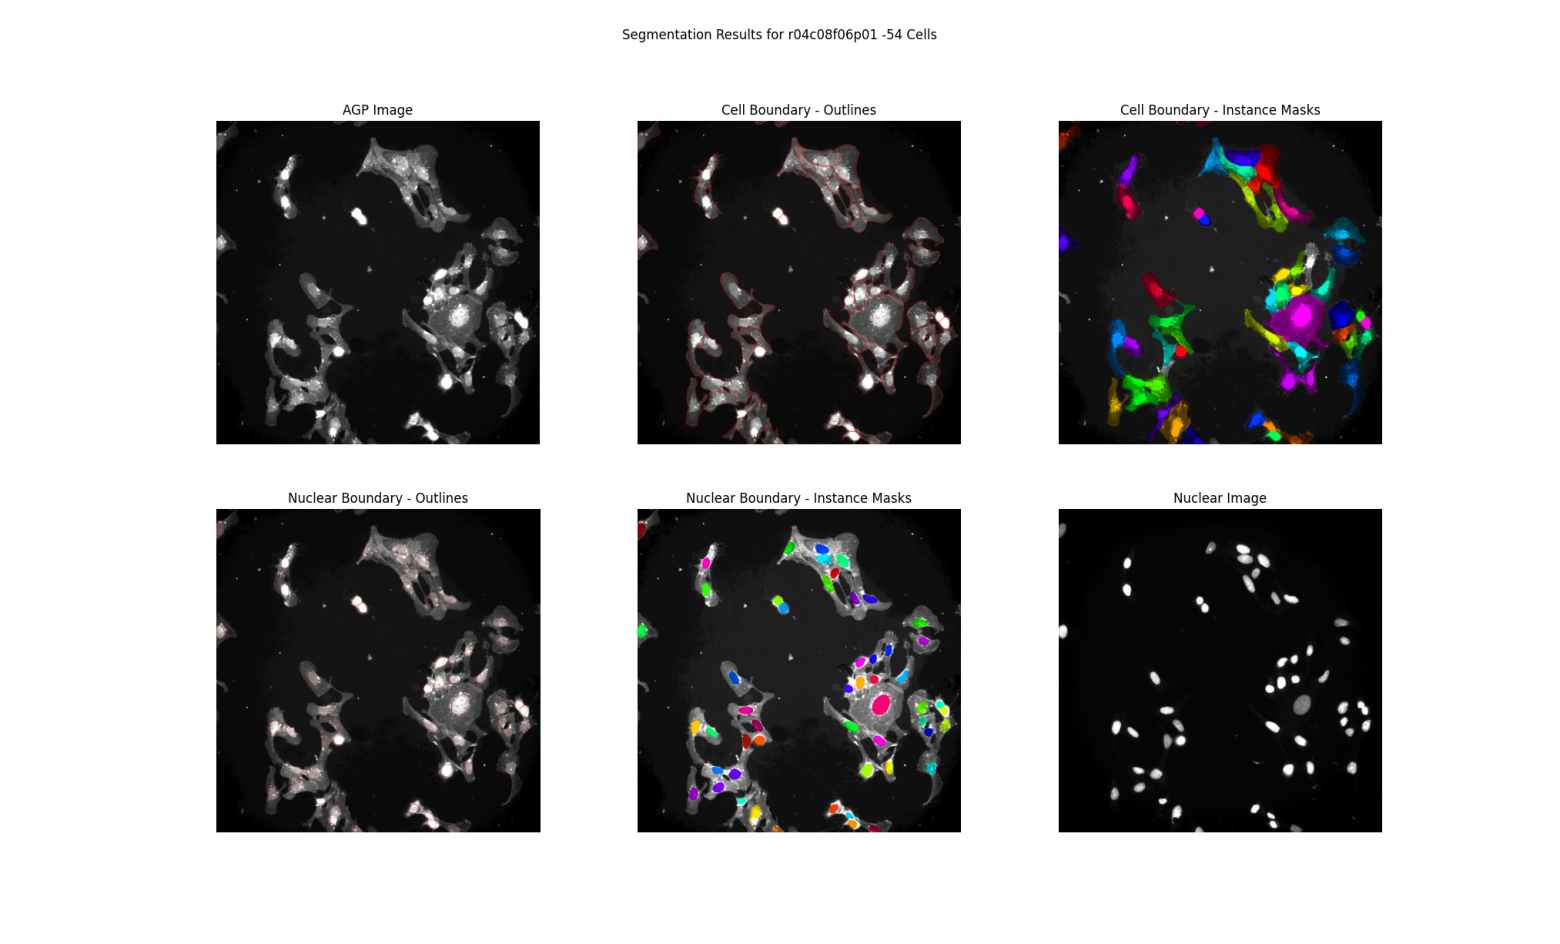

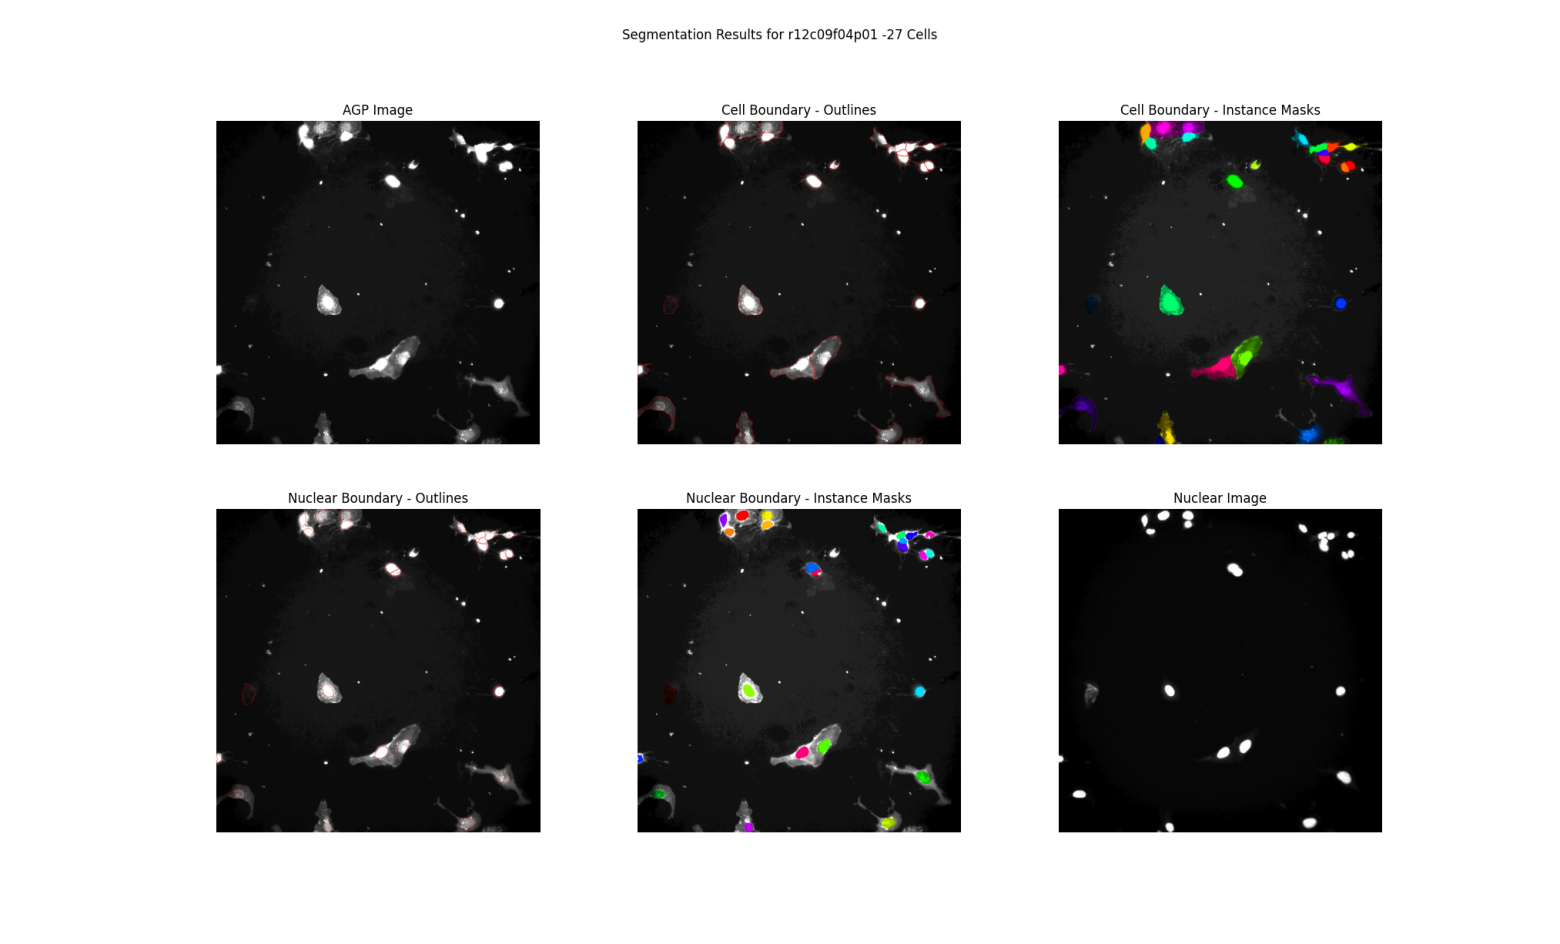

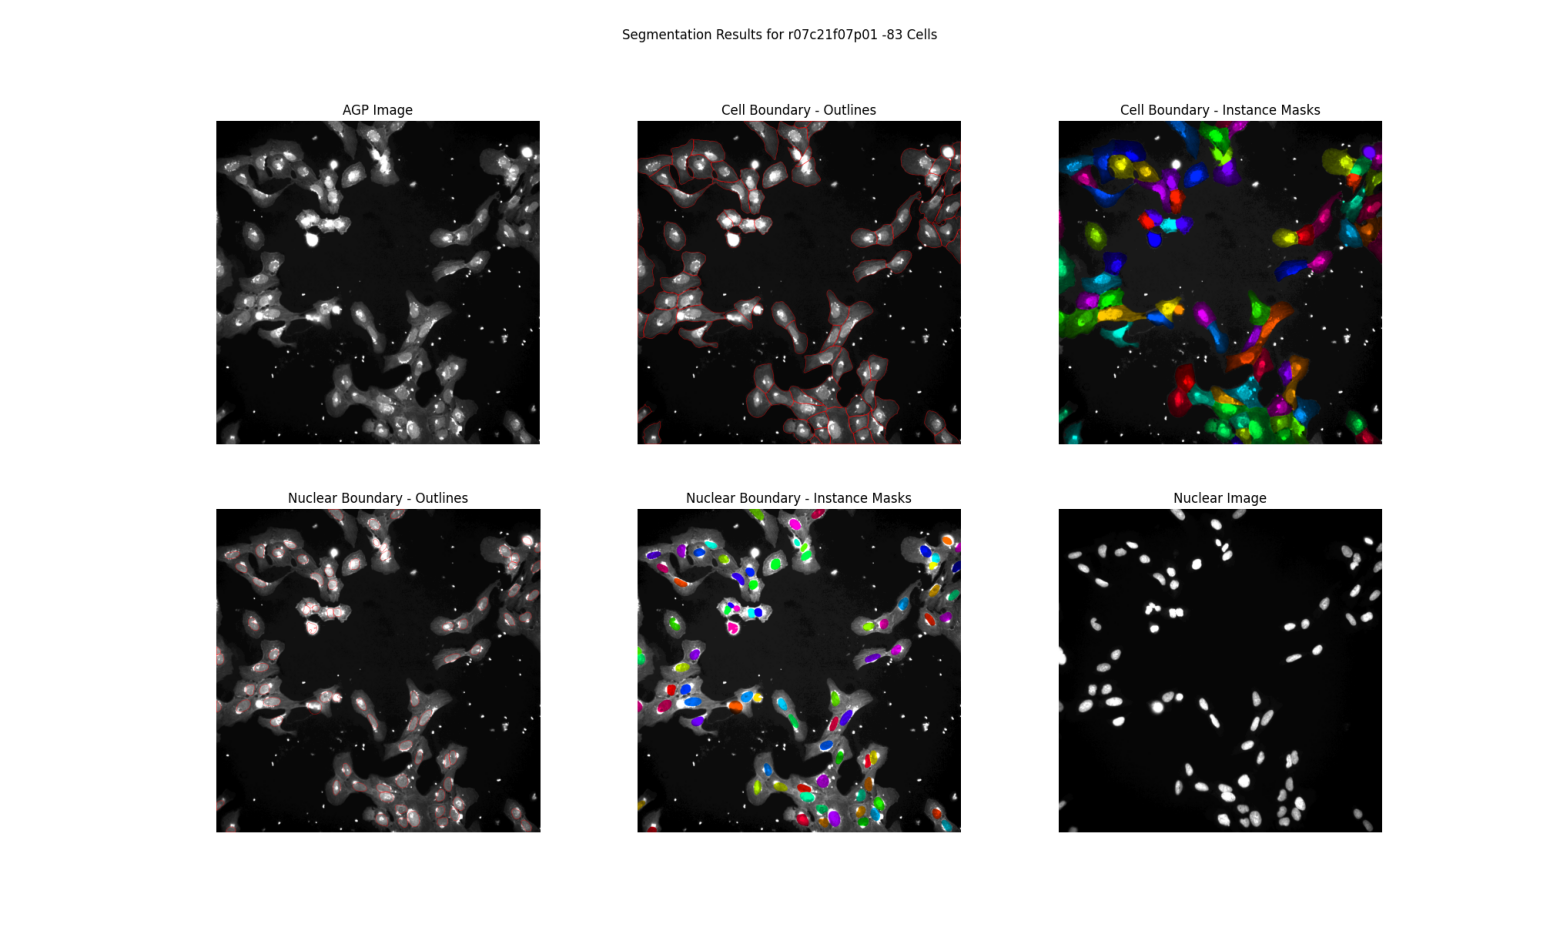

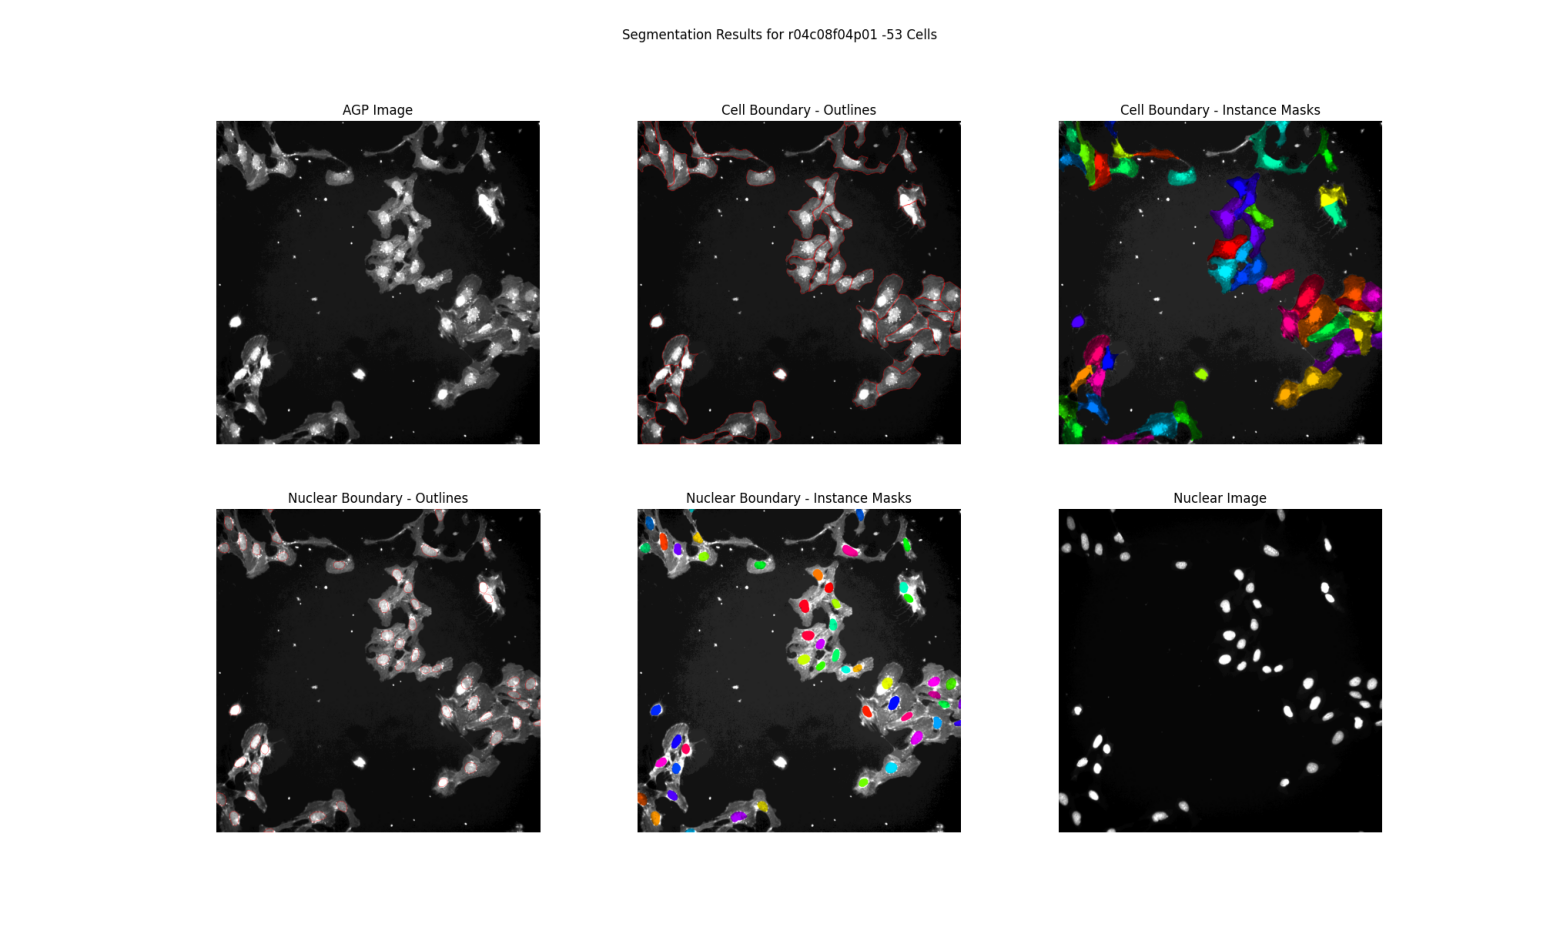

In [6]:
# SAVING IMAGES AT 'visualizations_3' Sub-directory
save_highlighted_images(agp_imgs,nucleus_imgs, cell_boundary_masks, nucleus_masks, agp_paths,'visualizations_3')

# PLOTTING 5 RANDOM IMAGES 
plot_highlighted_images(input_subdir = 'visualizations_3', num_images = 5 )

# CELL COUNTS FOR ALL IMAGES
cell_counts = count_cells(cell_boundary_masks)

In [7]:
# SAVING RESULTS ANS SHOWING NUMBER OF CELLS PER FIELD (BEFORE PRE-PROCESSING)

results = pd.DataFrame({
    'row': nuc_rows,
    'col': nuc_cols,
    'field': nuc_fields,
    'cell_count': cell_counts
})

cells_per_fov = results.groupby(['row', 'col', 'field']).agg({'cell_count': 'sum'}).reset_index()
cells_per_fov.columns = ['Row', 'Column', 'Field of View', 'Number of Cells']

pd.set_option('display.max_rows', None)
cells_per_fov


Row  Column  Field of View  Number of Cells
0     3      18              1               86
1     3      18              2              114
2     3      18              3              110
3     3      18              4              127
4     3      18              5              132
5     3      18              6              117
6     3      18              7               91
7     3      18              8              125
8     3      18              9              103
9     4       8              1               75
10    4       8              2               65
11    4       8              3               35
12    4       8              4               53
13    4       8              5               64
14    4       8              6               54
15    4       8              7               38
16    4       8              8               81
17    4       8              9               70
18    5      18              1              114
19    5      18              2              105
20    5      18              3               99
21    5      18              4              120
22    5      18              5              104
23    5      18              6               86
24    5      18              7               83
25    5      18              8              118
26    5      18              9              110
27    7      18              1              141
28    7      18              2              136
29    7      18              3              113
30    7      18              4              103
31    7      18              5               66
32    7      18              6              100
33    7      18              7              111
34    7      18              8               97
35    7      18              9               54
36    7      21              1               86
37    7      21              2               48
38    7      21              3               98
39    7      21              4               83
40    7      21              5               52
41    7      21              6               75
42    7      21              7               83
43    7      21              8               82
44    7      21              9              117
45   12       9              1               44
46   12       9              2               58
47   12       9              3               38
48   12       9              4               27
49   12       9              5               48
50   12       9              6               63
51   12       9              7               86
52   12       9              8               69
53   12       9              9               58
54   14      14              1               66
55   14      14              2              109
56   14      14              3               62
57   14      14              4               85
58   14      14              5              101
59   14      14              6               87
60   14      14              7              102
61   14      14              8               87
62   14      14              9               97

In [8]:
pd.reset_option('all')

/usr/local/lib/python3.9/dist-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


POST PROCESSING

In [9]:
max_distance = 50

# CREATING EMPTY LISTS TO STORE CELL AND NUCLEUS MASKS, CELLS TO NUCLEUS MAPPER AND NUCLEUS TO CELL MAPPER
new_cell_boundary_masks, new_nucleus_masks, cells_to_nucleus, nucleus_to_cells = [], [],[], []

# A FUNCTION WHICH TAKES CELL AND NUCLEUS MASK AS INPUT AND OUTPUTS MASKS AND MAPPER AFTER POST-PROCESSING
# overlap_threshold is a parameter that is used to control how much a nuclie and cell should overlap to map a specific nuclie to a cell.
# area_threshold is a parameter that compares nuclie and cell before matching them. By default if the nuclie size is greater than 92% of the cell size it is not considered.
# Redundant cells and nucleus aaree removed
def match_cells_and_nuclei(cell_mask, nucleus_mask, overlap_threshold=0.95, area_threshold = 0.92):
    cell_props = regionprops(cell_mask)
    nucleus_props = regionprops(nucleus_mask)

    new_cell_mask = np.zeros_like(cell_mask)
    new_nucleus_mask = np.zeros_like(nucleus_mask)

    
    nuclei_to_cell_map = {}
    cell_to_nuclei_map = {}

    for nucleus_label, nucleus_prop in zip([p.label for p in nucleus_props], nucleus_props):
        max_overlap = 0
        matching_cell_label = None
        nucleus_area = nucleus_prop.area

        for cell_label, cell_prop in zip([p.label for p in cell_props], cell_props):
            intersection_area = np.sum((cell_mask == cell_label) & (nucleus_mask == nucleus_label))
            overlap_ratio = intersection_area / nucleus_area
            cell_area = cell_prop.area

            if overlap_ratio > max_overlap and nucleus_area < cell_area * area_threshold:
                max_overlap = overlap_ratio
                matching_cell_label = cell_label

        if max_overlap >= overlap_threshold:
            nuclei_to_cell_map[nucleus_label] = matching_cell_label
            if matching_cell_label in cell_to_nuclei_map:
              cell_to_nuclei_map[matching_cell_label].append(nucleus_label)
            else:
              cell_to_nuclei_map[matching_cell_label] = [nucleus_label]

    for nucleus_label, cell_label in nuclei_to_cell_map.items():
        new_cell_mask[cell_mask == cell_label] = cell_label
        new_nucleus_mask[nucleus_mask == nucleus_label] = nucleus_label

    return new_cell_mask, new_nucleus_mask, cell_to_nuclei_map, nuclei_to_cell_map


# BY DEFAULT THE CELLS AT THE CORNER OF THE IMAGE IS CONSIDEERD BY CELLPOSE. 
# HOWEVER, IF WE CALCULATE FEATURES ON THE CELLS THAT LIE IN THE CORNER, THERE IS A RISK ASSOCIATED WITH IT
# HENCE CORNER CELLS AND ASSOCIATED NUCLEUS ARE REMOVED
def remove_corner_cells_and_nuclei(cell_mask, nucleus_mask, cells_to_nuclei_map, nucleus_to_cell_map):

    cell_props = regionprops(cell_mask)
    nucleus_props = regionprops(nucleus_mask)
    new_cells_to_nuclei_map = cells_to_nuclei_map.copy()
    new_nucleus_to_cell_map = nucleus_to_cell_map.copy()

    for cell_prop in cell_props:
        cell_label = cell_prop.label
        coords = cell_prop.coords

        if np.any(coords[:, 0] == 0) or np.any(coords[:, 0] == cell_mask.shape[0]-1) or np.any(coords[:, 1] == 0) or np.any(coords[:, 1] == cell_mask.shape[1]-1):
            if cell_label in new_cells_to_nuclei_map:
                del new_cells_to_nuclei_map[cell_label]
            
            updated_nucleus_to_cell_map = {}
            for nucleus_label, matched_cell_label in new_nucleus_to_cell_map.items():
                if matched_cell_label != cell_label:
                    updated_nucleus_to_cell_map[nucleus_label] = matched_cell_label

            new_nucleus_to_cell_map = updated_nucleus_to_cell_map

            cell_mask[cell_mask == cell_label] = 0

    for nucleus_prop in nucleus_props:
        nucleus_label = nucleus_prop.label
        coords = nucleus_prop.coords
        if np.any(coords[:, 0] == 0) or np.any(coords[:, 0] == nucleus_mask.shape[0]-1) or np.any(coords[:, 1] == 0) or np.any(coords[:, 1] == nucleus_mask.shape[1]-1):
            if nucleus_label in new_nucleus_to_cell_map:
                del new_nucleus_to_cell_map[nucleus_label]
            for cell_label, nuclei_labels in new_cells_to_nuclei_map.items():
                if nucleus_label in nuclei_labels:
                    new_cells_to_nuclei_map[cell_label].remove(nucleus_label)

            nucleus_mask[nucleus_mask == nucleus_label] = 0

    return cell_mask, nucleus_mask, new_cells_to_nuclei_map, new_nucleus_to_cell_map

# SOME OF THE CELLS DETECTED BY THE SEGMENTATION ALGORITHM MAY BE DEBRIS AND RANDOM NOISE. 
# THIS FUNCTION IS USED TO REMOVE CELLS UNDER CERTAIN 'area_threshold'
def remove_small_cells(cell_mask, nucleus_mask, cells_to_nuclei_map, nucleus_to_cell_map, area_threshold):
    cell_props = regionprops(cell_mask)
    nucleus_props = regionprops(nucleus_mask)
    new_cells_to_nuclei_map = cells_to_nuclei_map.copy()
    new_nucleus_to_cell_map = nucleus_to_cell_map.copy()

    for cell_prop in cell_props:
        cell_label = cell_prop.label
        cell_area = cell_prop.area

        if cell_area < area_threshold:
            if cell_label in new_cells_to_nuclei_map:
              
                for nucleus_label in cells_to_nuclei_map[cell_label]:
                    if nucleus_label in new_nucleus_to_cell_map:
                        del new_nucleus_to_cell_map[nucleus_label]

                del new_cells_to_nuclei_map[cell_label]

                for nuclei_labels in new_cells_to_nuclei_map.values():
                    if cell_label in nuclei_labels:
                        nuclei_labels.remove(cell_label)

            cell_mask[cell_mask == cell_label] = 0

    return cell_mask, nucleus_mask, new_cells_to_nuclei_map, new_nucleus_to_cell_map


# RUNNING ALL THE POST-PROCESSING STEPS ON ALL THE IMAGES AND GETTING THE NEW MASKS

counter = 0

for cell_mask, nucleus_mask in zip(cell_boundary_masks, nucleus_masks):

    new_cell_boundary_mask,new_nucleus_bound_mask, cells_to_nuclei_map, nucleus_to_cell_map =  match_cells_and_nuclei(cell_mask, nucleus_mask)
    new_cell_boundary_mask,new_nucleus_bound_mask, cells_to_nuclei_map, nucleus_to_cell_map = remove_corner_cells_and_nuclei(new_cell_boundary_mask,new_nucleus_bound_mask, cells_to_nuclei_map, nucleus_to_cell_map)
    new_cell_boundary_mask,new_nucleus_bound_mask, cells_to_nuclei_map, nucleus_to_cell_map = remove_small_cells(new_cell_boundary_mask,new_nucleus_bound_mask, cells_to_nuclei_map,nucleus_to_cell_map, 700 )


    new_cell_boundary_masks.append(new_cell_boundary_mask)
    new_nucleus_masks.append(new_nucleus_bound_mask)
    cells_to_nucleus.append(cells_to_nuclei_map)
    nucleus_to_cells.append(nucleus_to_cell_map)


    counter += 1
    print(str(counter) + ' images done')




1 images done
2 images done
3 images done
4 images done
5 images done
6 images done
7 images done
8 images done
9 images done
10 images done
11 images done
12 images done
13 images done
14 images done
15 images done
16 images done
17 images done
18 images done
19 images done
20 images done
21 images done
22 images done
23 images done
24 images done
25 images done
26 images done
27 images done
28 images done
29 images done
30 images done
31 images done
32 images done
33 images done
34 images done
35 images done
36 images done
37 images done
38 images done
39 images done
40 images done
41 images done
42 images done
43 images done
44 images done
45 images done
46 images done
47 images done
48 images done
49 images done
50 images done
51 images done
52 images done
53 images done
54 images done
55 images done
56 images done
57 images done
58 images done
59 images done
60 images done
61 images done
62 images done
63 images done


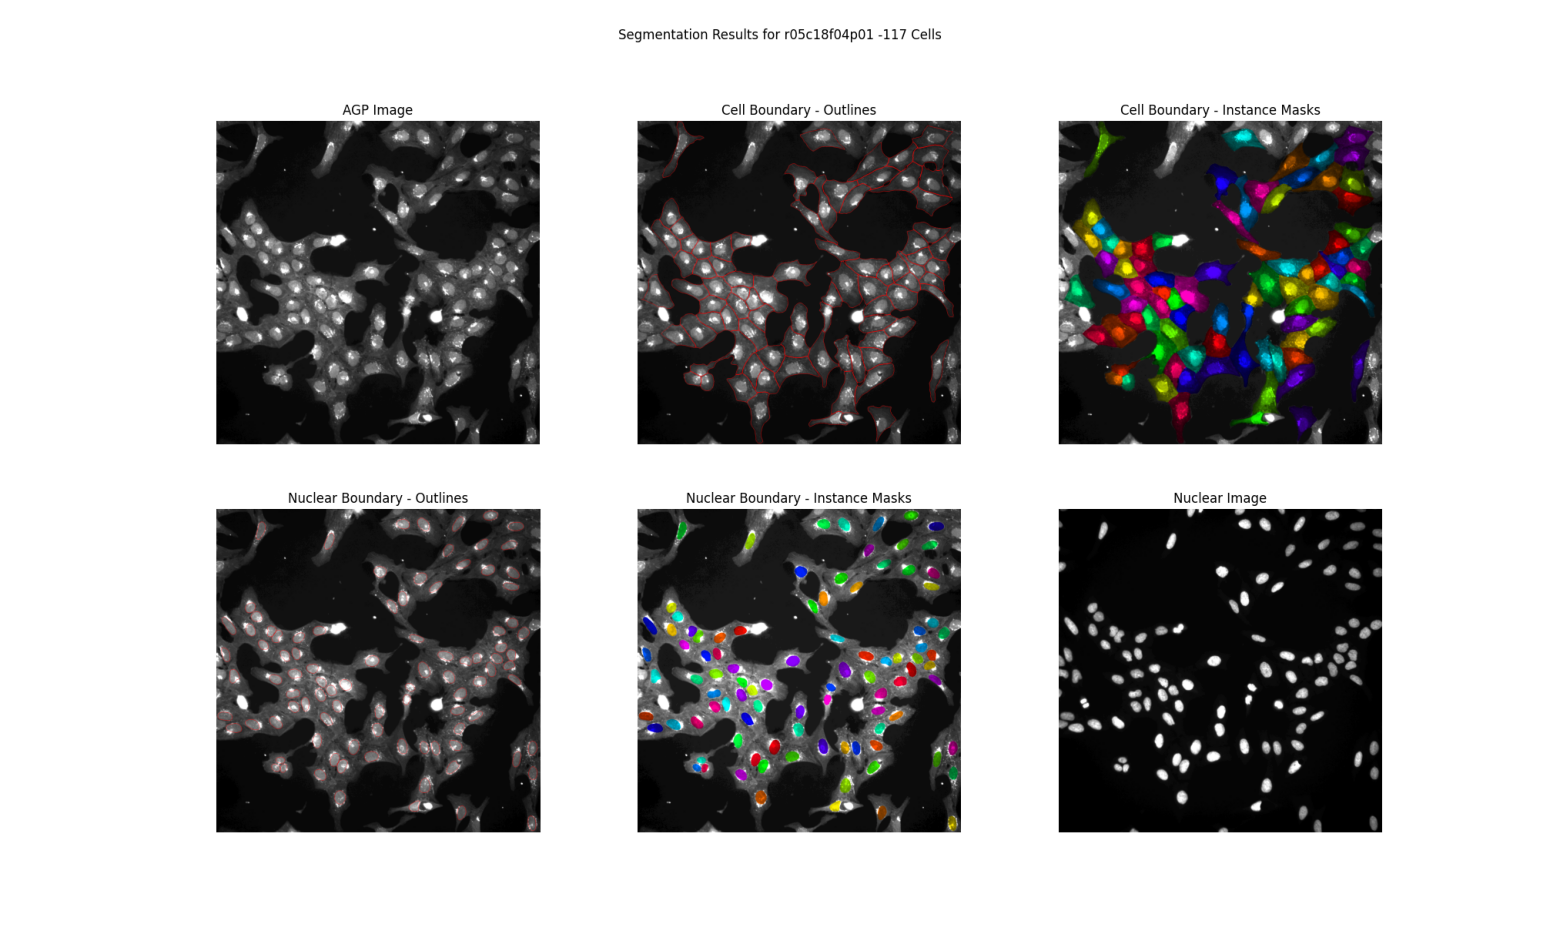

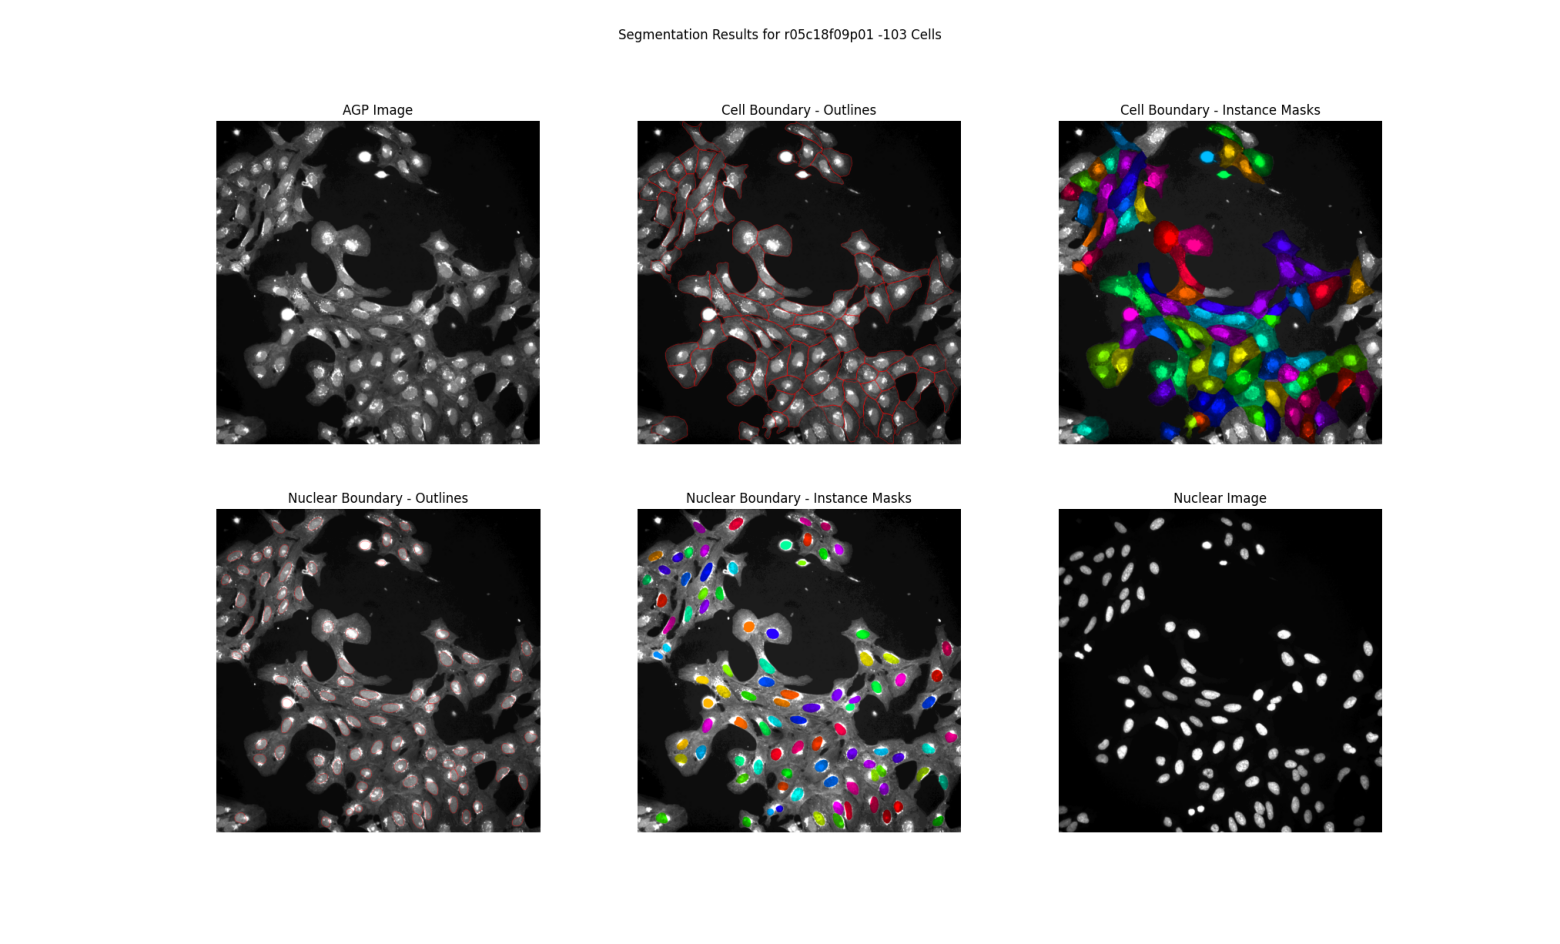

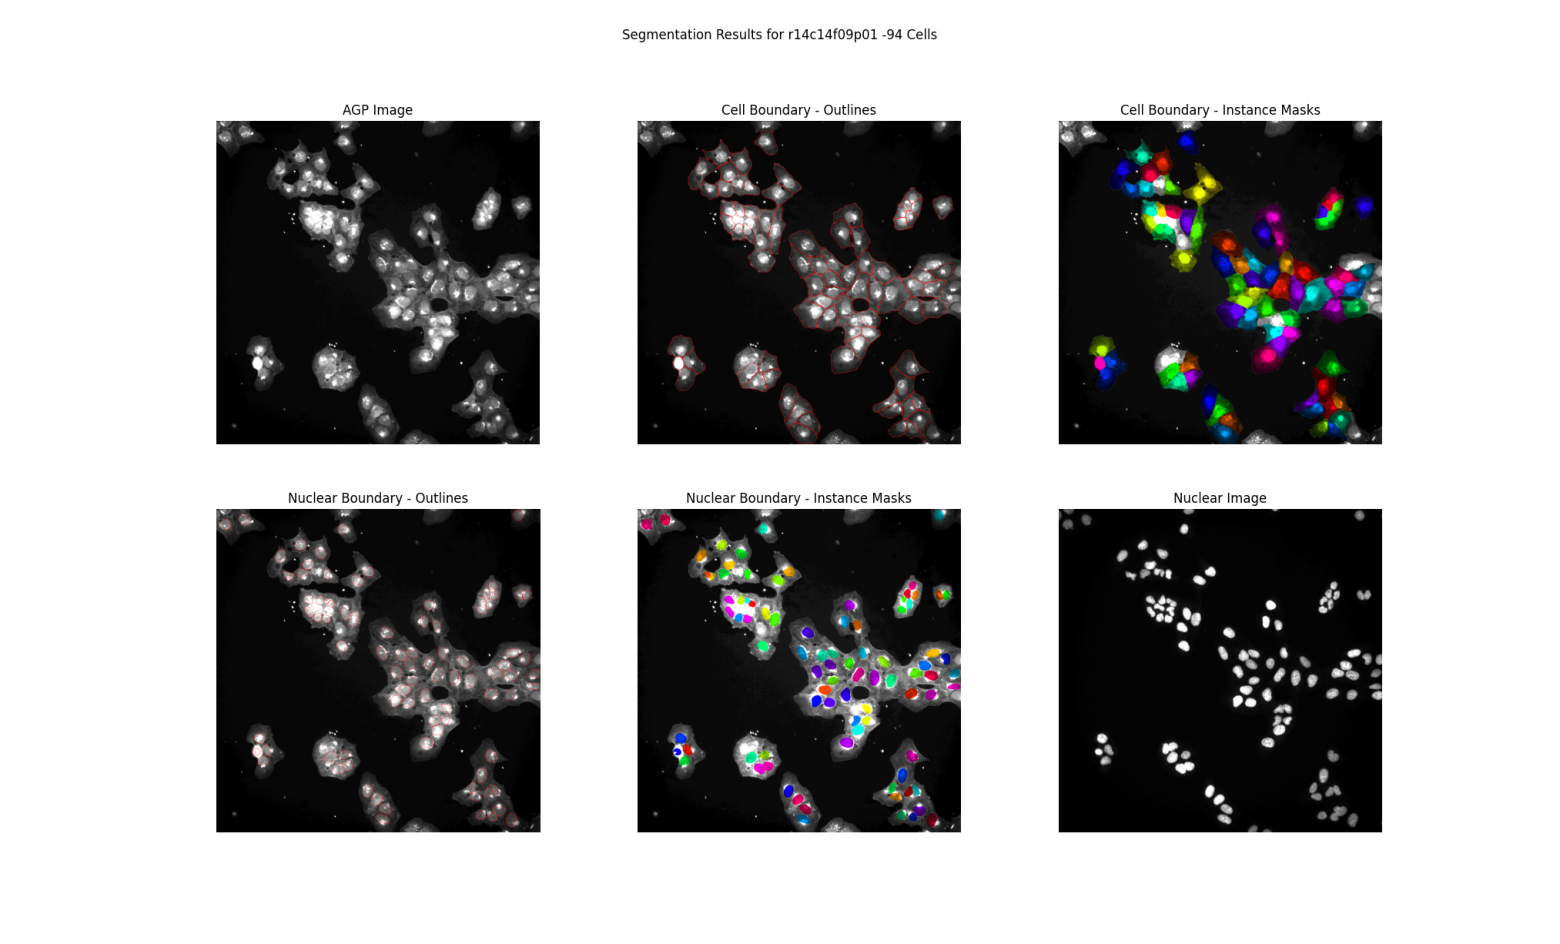

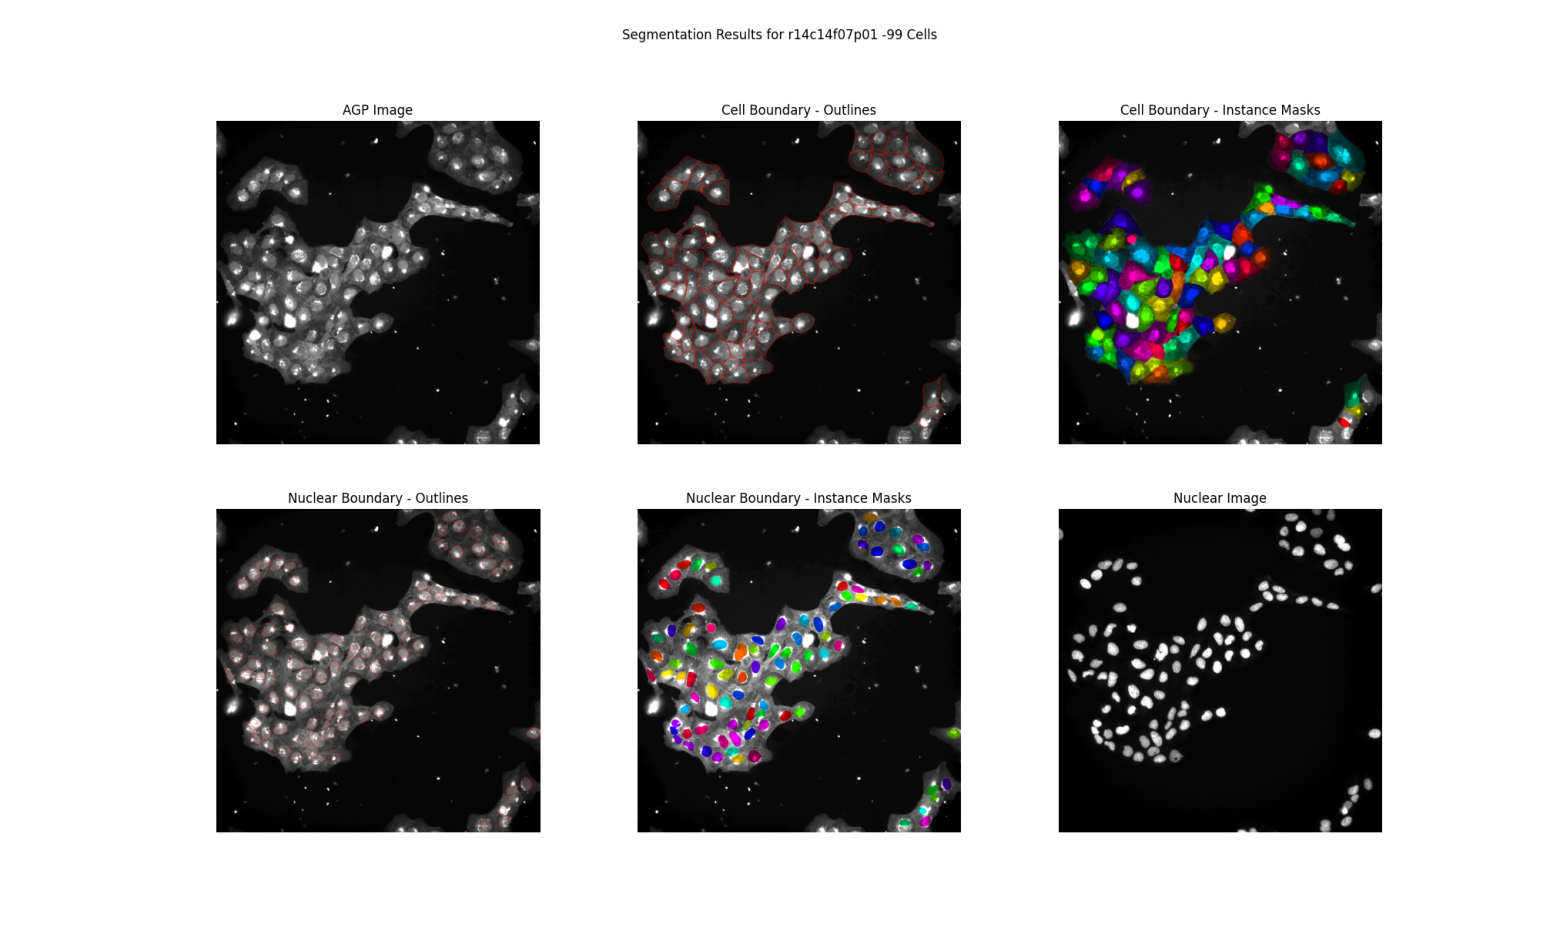

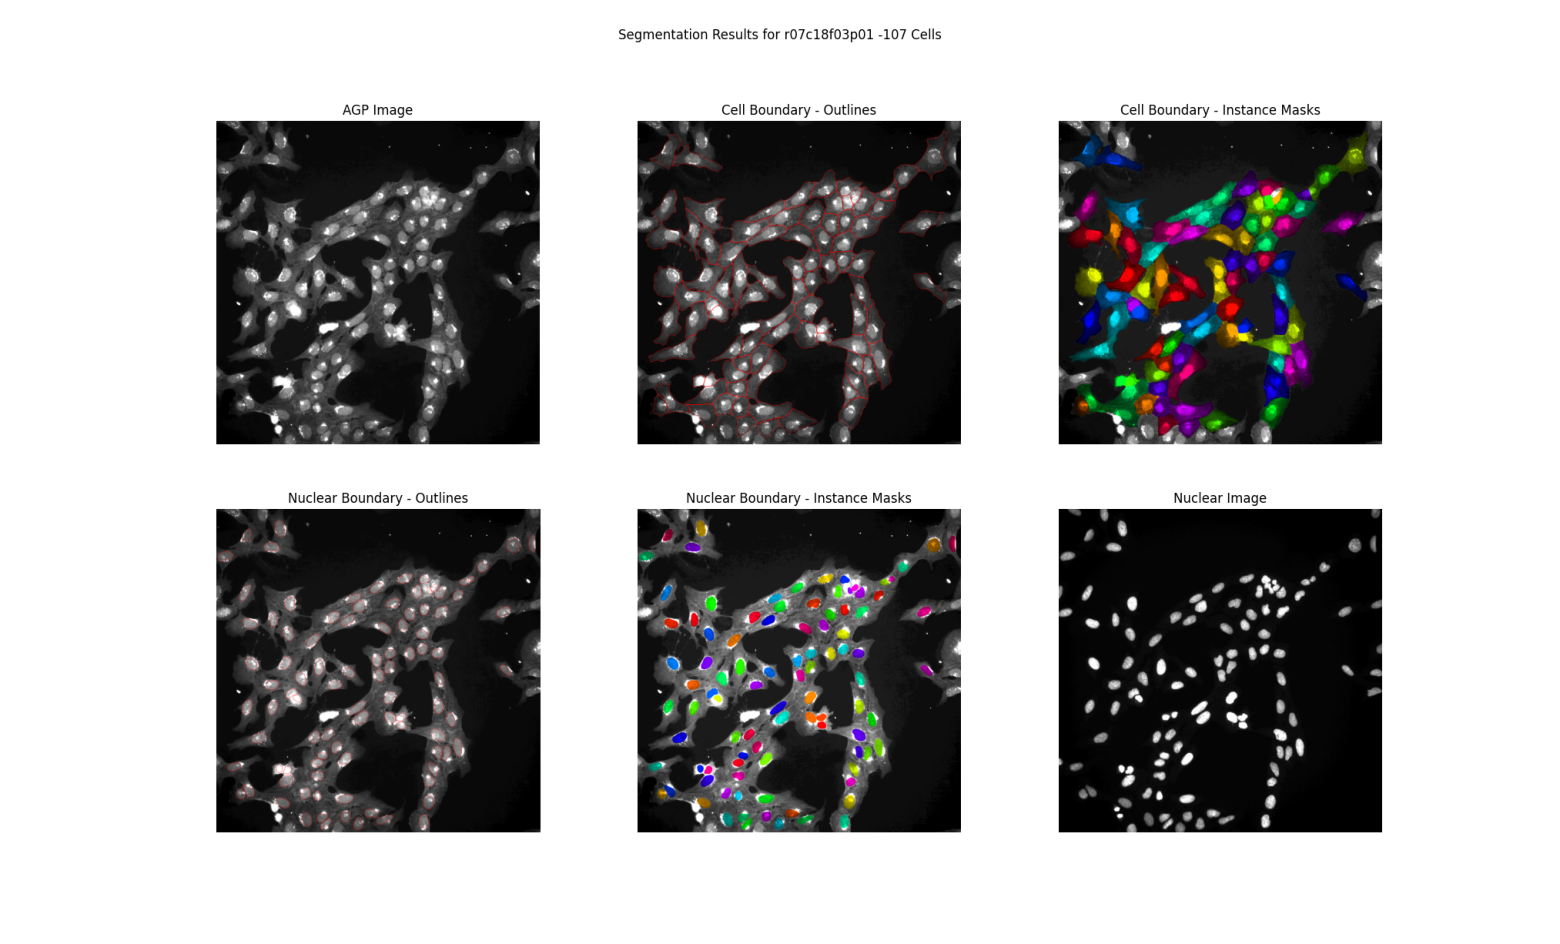

In [10]:
# SAVING THE POST PROCESSED OUTPUT VISUALIZATIONS TO postpro_3
save_highlighted_images(agp_imgs,nucleus_imgs, new_cell_boundary_masks, new_nucleus_masks, agp_paths,'postpro_3')

# PLOTTING 5 RANDOM SEGMENTATION VISUALIZATIONS AFTER POST-PROCESSING
plot_highlighted_images(input_subdir = 'postpro_3', num_images = 5 )

In [11]:
# THE BELOW RESULTS INDICATES THAT WE HAVE FILTERED RESULTS IN 58/63 IMAGES.
new_cell_counts = count_cells(new_cell_boundary_masks)
results['Number of Cells- Post Processed'] = new_cell_counts 

(results['cell_count'] != results['Number of Cells- Post Processed']).sum()

58

In [12]:
# DISPLAYING NUMBER OF CELLS PER FOV AFTER POST-PROCESSING
cells_per_fov_new = results.groupby(['row', 'col', 'field']).agg({'cell_count': 'sum', 'Number of Cells- Post Processed': 'sum'}).reset_index()
cells_per_fov_new.columns = ['Row', 'Column', 'Field of View','Number of Cells', 'Number of Cells- Post Processed']

pd.set_option('display.max_rows', None)
cells_per_fov_new

Row  Column  Field of View  Number of Cells  \
0     3      18              1               86   
1     3      18              2              114   
2     3      18              3              110   
3     3      18              4              127   
4     3      18              5              132   
5     3      18              6              117   
6     3      18              7               91   
7     3      18              8              125   
8     3      18              9              103   
9     4       8              1               75   
10    4       8              2               65   
11    4       8              3               35   
12    4       8              4               53   
13    4       8              5               64   
14    4       8              6               54   
15    4       8              7               38   
16    4       8              8               81   
17    4       8              9               70   
18    5      18              1              114   
19    5      18              2              105   
20    5      18              3               99   
21    5      18              4              120   
22    5      18              5              104   
23    5      18              6               86   
24    5      18              7               83   
25    5      18              8              118   
26    5      18              9              110   
27    7      18              1              141   
28    7      18              2              136   
29    7      18              3              113   
30    7      18              4              103   
31    7      18              5               66   
32    7      18              6              100   
33    7      18              7              111   
34    7      18              8               97   
35    7      18              9               54   
36    7      21              1               86   
37    7      21              2               48   
38    7      21              3               98   
39    7      21              4               83   
40    7      21              5               52   
41    7      21              6               75   
42    7      21              7               83   
43    7      21              8               82   
44    7      21              9              117   
45   12       9              1               44   
46   12       9              2               58   
47   12       9              3               38   
48   12       9              4               27   
49   12       9              5               48   
50   12       9              6               63   
51   12       9              7               86   
52   12       9              8               69   
53   12       9              9               58   
54   14      14              1               66   
55   14      14              2              109   
56   14      14              3               62   
57   14      14              4               85   
58   14      14              5              101   
59   14      14              6               87   
60   14      14              7              102   
61   14      14              8               87   
62   14      14              9               97   

    Number of Cells- Post Processed  
0                                85  
1                               107  
2                               106  
3                               124  
4                               126  
5                               111  
6                                83  
7                               118  
8                                98  
9                                71  
10                               64  
11                               32  
12                               50  
13                               64  
14                               54  
15                               37  
16                               73  
17                               68  
18               

In [13]:
pd.reset_option('all')

/usr/local/lib/python3.9/dist-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [14]:
# Calculating area of the cell, the area of the nucleus, the length of the major and minor axis of the cell, and the perimeter of the cell.
def calculate_measurements_using_regionprops(cell_mask, nuclei_mask):


    cell_props = regionprops_table(cell_mask, properties=('area', 'perimeter', 'major_axis_length', 'minor_axis_length'))
    nucleus_props = regionprops_table(nuclei_mask, properties=('area',))

    if len(nucleus_props['area']) == 0:

      measurements = (
        cell_props['area'][0],
        -1,
        cell_props['major_axis_length'][0],
        cell_props['minor_axis_length'][0],
        cell_props['perimeter'][0],
          )
      
    else:

        measurements = (
            cell_props['area'][0],
            nucleus_props['area'][0],
            cell_props['major_axis_length'][0],
            cell_props['minor_axis_length'][0],
            cell_props['perimeter'][0],
        )

    return measurements

# Wrapper for calculate_measurements_using_regionprops at image level ( Some additional features are also included )
def process_images(new_cell_boundary_masks, new_nucleus_masks, cells_to_nucleus):
    results = []

    for img_idx in range(len(new_cell_boundary_masks)):
        cell_boundary_mask = new_cell_boundary_masks[img_idx]
        nucleus_mask = new_nucleus_masks[img_idx]
        cell_to_nucleus_map = cells_to_nucleus[img_idx]

        img_data = []

        for cell_id, nucleus_ids in cell_to_nucleus_map.items():
            cell_mask = (cell_boundary_mask == cell_id).astype(np.uint8)
            nuclei_mask = np.zeros_like(nucleus_mask)
            for nucleus_id in nucleus_ids:
                nuclei_mask += (nucleus_mask == nucleus_id).astype(np.uint8)

            measurements = calculate_measurements_using_regionprops(cell_mask, nuclei_mask)

            img_data.append({
                'image_idx': img_idx,
                'cell_id': cell_id,
                'nucleus_ids': ','.join(map(str, nucleus_ids)),
                'cell_area': measurements[0],
                'nucleus_area': measurements[1],
                'nucleus_cytoplasm_ratio': measurements[1]/ (measurements[0] - measurements[1]),
                'nucleus_cell_ratio': measurements[1] / measurements[0],
                'major_axis_length': measurements[2],
                'minor_axis_length': measurements[3],
                'cell_perimeter': measurements[4],
                'num_nuclie': len(nucleus_ids)
            })
      
        img_results = pd.DataFrame(img_data)
        results.append(img_results)

    final_results = pd.concat(results, ignore_index=True)

    return final_results

step_2_results = process_images(new_cell_boundary_masks, new_nucleus_masks, cells_to_nucleus)

In [15]:
# Loading images from all channels to calculate intensity values
channels_mitochondria = np.full_like(rows, 1)
channels_rna = np.full_like(rows, 3)
channels_er = np.full_like(rows, 4)

mitochondria_imgs, _,_,_,_,_ = load_images(rows, cols, fields, channels_mitochondria)
rna_imgs, _,_,_,_,_= load_images(rows, cols, fields, channels_rna)
er_imgs, _,_,_,_,_ = load_images(rows, cols, fields, channels_er)

In [16]:
num_images = len(mitochondria_imgs)
image_sets = [[mitochondria_imgs[i],agp_imgs[i],rna_imgs[i],er_imgs[i],nucleus_imgs[i]]
              for i in range(num_images)]

In [17]:
# FUNCTION TO CALCULATE INTENSITY MEASURES

def process_channel_intensities(new_cell_boundary_masks, new_nucleus_masks, cells_to_nucleus, image_sets):

    results = []

    for img_idx in range(len(new_cell_boundary_masks)):
        cell_boundary_mask = new_cell_boundary_masks[img_idx]
        nucleus_mask = new_nucleus_masks[img_idx]
        cell_to_nucleus_map = cells_to_nucleus[img_idx]
        img_channels = image_sets[img_idx]

        img_data = []

        for cell_id, nucleus_ids in cell_to_nucleus_map.items():
            cell_mask = (cell_boundary_mask == cell_id).astype(np.uint8)

            nuclei_mask = np.zeros_like(nucleus_mask)

            for nucleus_id in nucleus_ids:
                nuclei_mask += (nucleus_mask == nucleus_id).astype(np.uint8)

            cytoplasm_mask = cell_mask - nuclei_mask

            cell_data = {'image_idx': img_idx, 'cell_id': cell_id, 'nucleus_ids': ','.join(map(str, nucleus_ids))}

            for channel_idx, channel in enumerate(img_channels):

                for region_name, region_mask in zip(["cell", "nucleus", "cytoplasm"], [cell_mask, nuclei_mask, cytoplasm_mask]):

                    region_intensity = channel[region_mask.astype(bool)]

                    if len(region_intensity) == 0:
                      mean_intensity = -1
                      variance_intensity = -1
                      p10_intensity = -1
                      p90_intensity = -1

                    else:
                      mean_intensity = np.mean(region_intensity)
                      variance_intensity = np.var(region_intensity)
                      p10_intensity = np.percentile(region_intensity, 10)
                      p90_intensity = np.percentile(region_intensity, 90)

                    cell_data[f"channel_{channel_idx + 1}_{region_name}_mean"] = mean_intensity
                    cell_data[f"channel_{channel_idx + 1}_{region_name}_variance"] = variance_intensity
                    cell_data[f"channel_{channel_idx + 1}_{region_name}_p10"] = p10_intensity
                    cell_data[f"channel_{channel_idx + 1}_{region_name}_p90"] = p90_intensity

            img_data.append(cell_data)

        img_results = pd.DataFrame(img_data)
        results.append(img_results)

    final_results = pd.concat(results, ignore_index=True)

    return final_results

# CALCULATION OF INTENSITIES
step_3_results = process_channel_intensities(new_cell_boundary_masks, new_nucleus_masks, cells_to_nucleus, image_sets)


In [18]:
# A DATAFRAME OF INTENSITY VALUES
step_3_results

image_idx  cell_id nucleus_ids  channel_1_cell_mean  \
0             0        6           3             2.406922   
1             0        8           5             2.519421   
2             0       10           7             2.577647   
3             0        9           8             2.372722   
4             0       12           9             2.331439   
...         ...      ...         ...                  ...   
4053         62       90          98             5.038729   
4054         62       89          99             4.483227   
4055         62       92         100             4.560377   
4056         62       93         101             4.549718   
4057         62       94         103             5.191446   

      channel_1_cell_variance  channel_1_cell_p10  channel_1_cell_p90  \
0                    0.429271                 2.0                 3.0   
1                    0.702882                 2.0                 3.0   
2                    0.671765                 2.0                 4.0   
3                    0.518226                 2.0                 3.0   
4                    0.365285                 2.0                 3.0   
...                       ...                 ...                 ...   
4053                 1.190028                 4.0                 7.0   
4054                 1.828870                 3.0                 6.0   
4055                 1.383713                 3.0                 6.0   
4056                 1.468544                 3.0                 6.0   
4057                 4.631732                 4.0                 8.0   

      channel_1_nucleus_mean  channel_1_nucleus_variance  \
0                   2.772809                    0.409923   
1                   3.141190                    0.331291   
2                   3.288538                    0.256667   
3                   2.721798                    0.283927   
4                   2.542659                    0.264053   
...                      ...                         ...   
4053                5.268839                    0.634447   
4054                4.574956                    0.933976   
4055                5.138776                    0.443326   
4056                4.974843                    0.754084   
4057                5.614232                    1.515977   

      channel_1_nucleus_p10  ...  channel_5_cell_p10  channel_5_cell_p90  \
0                       2.0  ...                 1.0                17.0   
1                       3.0  ...                 2.0                21.0   
2                       3.0  ...                 2.0                14.0   
3                       2.0  ...                 1.0                21.0   
4                       2.0  ...                 2.0                20.0   
...                     ...  ...                 ...                 ...   
4053                    4.0  ...                 2.0                42.0   
4054                    4.0  ...                 2.0                28.0   
4055                    4.0  ...                 1.0                26.0   
4056                    4.0  ...                 1.0                28.0   
4057                    5.0  ...                 1.0                40.0   

      channel_5_nucleus_mean  channel_5_nucleus_variance  \
0                  16.971377                   14.573420   
1                  23.100350                   30.977094   
2                  19.178854                   15.751608   
3                  20.518236                   20.217437   
4                  19.598214                   25.611386   
...                      ...                         ...   
4053               37.789206                   63.864934   
4054               24.962081                   32.013553   
4055               23.197279                   32.522986   
4056               24.795597                   31.389037   
4057               37.557116                  102.705539   

      channel_5_nucleus_p10  channel_5_nu

In [19]:
step_2_prefixed, step_3_prefixed =  step_2_results.add_prefix('prop_'), step_3_results.add_prefix('intensity_')

# A MERGED DATAFRAME FOR PROPS AND INTENSITIES
props_plus_intensities = pd.merge(step_2_prefixed, step_3_prefixed, left_index=True, right_index=True, suffixes =('_props', '_intensity'))

props_plus_intensities

prop_image_idx  prop_cell_id prop_nucleus_ids  prop_cell_area  \
0                  0             6                3            6183   
1                  0             8                5            6076   
2                  0            10                7            8822   
3                  0             9                8            5323   
4                  0            12                9            4927   
...              ...           ...              ...             ...   
4053              62            90               98            3305   
4054              62            89               99            3607   
4055              62            92              100            2650   
4056              62            93              101            2303   
4057              62            94              103            4466   

      prop_nucleus_area  prop_nucleus_cytoplasm_ratio  \
0                  1118                      0.220731   
1                   857                      0.164208   
2                  1012                      0.129577   
3                  1179                      0.284508   
4                  1008                      0.257208   
...                 ...                           ...   
4053                982                      0.422729   
4054               1134                      0.458552   
4055                735                      0.383812   
4056                636                      0.381524   
4057               1068                      0.314303   

      prop_nucleus_cell_ratio  prop_major_axis_length  prop_minor_axis_length  \
0                    0.180818              149.180805               59.586239   
1                    0.141047              100.338557               80.820327   
2                    0.114713              176.109276               68.494589   
3                    0.221492              117.867671               62.519448   
4                    0.204587              140.502590               48.502900   
...                       ...                     ...                     ...   
4053                 0.297126               87.139893               53.464156   
4054                 0.314389               74.797120               68.262134   
4055                 0.277358               75.175063               46.195254   
4056                 0.276162               80.211171               44.944042   
4057                 0.239140               98.372783               58.387811   

      prop_cell_perimeter  ...  intensity_channel_5_cell_p10  \
0              389.948268  ...                           1.0   
1              319.303607  ...                           2.0   
2              452.132034  ...                           2.0   
3              330.634560  ...                           1.0   
4              353.303607  ...                           2.0   
...                   ...  ...                           ...   
4053           252.249783  ...                           2.0   
4054           269.735065  ...                           2.0   
4055           208.651804  ...                           1.0   
4056           245.800036  ...                           1.0   
4057           270.492424  ...                           1.0   

      intensity_channel_5_cell_p90  intensity_channel_5_nucleus_mean  \
0                             17.0                         16.971377   
1                             21.0                         23.100350   
2                             14.0                         19.178854   
3                             21.0                         20.518236   
4                             20.0                         19.598214   
...                            ...                               ...   
4053                          42.0                         37.789206   
4054                          28.0                         24.962081   
4055                          26.0                         23.197279   
4056  

In [20]:
all_feat_combined = pd.merge(results, props_plus_intensities, left_index = True, right_on = 'prop_image_idx')

## Removing redundant variables
all_feat_combined[all_feat_combined['prop_nucleus_area'] == -1]


row  col  field  cell_count  Number of Cells- Post Processed  \
931     4    8      5          64                               64   
3260   12    9      6          63                               60   

      prop_image_idx  prop_cell_id prop_nucleus_ids  prop_cell_area  \
931               13            12                             1291   
3260              50            40                             3307   

      prop_nucleus_area  ...  intensity_channel_5_cell_p10  \
931                  -1  ...                           3.0   
3260                 -1  ...                           2.0   

      intensity_channel_5_cell_p90  intensity_channel_5_nucleus_mean  \
931                           82.0                              -1.0   
3260                          46.0                              -1.0   

      intensity_channel_5_nucleus_variance  intensity_channel_5_nucleus_p10  \
931                                   -1.0                             -1.0   
3260                                  -1.0                             -1.0   

      intensity_channel_5_nucleus_p90  intensity_channel_5_cytoplasm_mean  \
931                              -1.0                           27.440744   
3260                             -1.0                           11.856668   

      intensity_channel_5_cytoplasm_variance  \
931                              1298.881655   
3260                              318.979153   

     intensity_channel_5_cytoplasm_p10  intensity_channel_5_cytoplasm_p90  
931                                3.0                               82.0  
3260                               2.0                               46.0  

[2 rows x 79 columns]

In [21]:
all_feat_combined = all_feat_combined[all_feat_combined['prop_nucleus_area'] != -1]

# A DATAFRAME CONTAINING ALL FEATURS OBTAINED FROM STEP 1-3
all_feat_combined

row  col  field  cell_count  Number of Cells- Post Processed  \
0       3   18      1          86                               85   
1       3   18      1          86                               85   
2       3   18      1          86                               85   
3       3   18      1          86                               85   
4       3   18      1          86                               85   
...   ...  ...    ...         ...                              ...   
4053   14   14      9          97                               94   
4054   14   14      9          97                               94   
4055   14   14      9          97                               94   
4056   14   14      9          97                               94   
4057   14   14      9          97                               94   

      prop_image_idx  prop_cell_id prop_nucleus_ids  prop_cell_area  \
0                  0             6                3            6183   
1                  0             8                5            6076   
2                  0            10                7            8822   
3                  0             9                8            5323   
4                  0            12                9            4927   
...              ...           ...              ...             ...   
4053              62            90               98            3305   
4054              62            89               99            3607   
4055              62            92              100            2650   
4056              62            93              101            2303   
4057              62            94              103            4466   

      prop_nucleus_area  ...  intensity_channel_5_cell_p10  \
0                  1118  ...                           1.0   
1                   857  ...                           2.0   
2                  1012  ...                           2.0   
3                  1179  ...                           1.0   
4                  1008  ...                           2.0   
...                 ...  ...                           ...   
4053                982  ...                           2.0   
4054               1134  ...                           2.0   
4055                735  ...                           1.0   
4056                636  ...                           1.0   
4057               1068  ...                           1.0   

      intensity_channel_5_cell_p90  intensity_channel_5_nucleus_mean  \
0                             17.0                         16.971377   
1                             21.0                         23.100350   
2                             14.0                         19.178854   
3                             21.0                         20.518236   
4                             20.0                         19.598214   
...                            ...                               ...   
4053                          42.0                         37.789206   
4054                          28.0                         24.962081   
4055                          26.0                         23.197279   
4056                          28.0                         24.795597   
4057                          40.0                         37.557116   

      intensity_channel_5_nucleus_variance  intensity_channel_5_nucleus_p10  \
0                                14.573420                             11.0   
1                                30.977094                             15.0   
2                                15.751608                             13.0   
3                                20.217437                             14.8   
4                                25.611386                             12.0   
...                                    ...                              ...   
4053                             63.864934                             25.0   
4054                             32.013553                            

In [22]:
# FUNCTION TO CREATE WELL PATTERN

def create_pattern(row):
    return f"r{row['row']:02d}c{row['col']:02d}"

all_feat_combined['well'] = all_feat_combined[['row','col']].apply(create_pattern, axis=1)

In [23]:
# SHOWING ALL THE FEATURES OBTAINED
reqd_feats = all_feat_combined.columns[:-1].difference(['row','col','field','prop_image_idx','prop_cell_id',
                                           'prop_nucleus_ids', 'intensity_image_idx', 'intensity_cell_id', 'intensity_nucleus_ids'])
reqd_feats

Index(['Number of Cells- Post Processed', 'cell_count',
       'intensity_channel_1_cell_mean', 'intensity_channel_1_cell_p10',
       'intensity_channel_1_cell_p90', 'intensity_channel_1_cell_variance',
       'intensity_channel_1_cytoplasm_mean',
       'intensity_channel_1_cytoplasm_p10',
       'intensity_channel_1_cytoplasm_p90',
       'intensity_channel_1_cytoplasm_variance',
       'intensity_channel_1_nucleus_mean', 'intensity_channel_1_nucleus_p10',
       'intensity_channel_1_nucleus_p90',
       'intensity_channel_1_nucleus_variance', 'intensity_channel_2_cell_mean',
       'intensity_channel_2_cell_p10', 'intensity_channel_2_cell_p90',
       'intensity_channel_2_cell_variance',
       'intensity_channel_2_cytoplasm_mean',
       'intensity_channel_2_cytoplasm_p10',
       'intensity_channel_2_cytoplasm_p90',
       'intensity_channel_2_cytoplasm_variance',
       'intensity_channel_2_nucleus_mean', 'intensity_channel_2_nucleus_p10',
       'intensity_channel_2_nucleus_p90

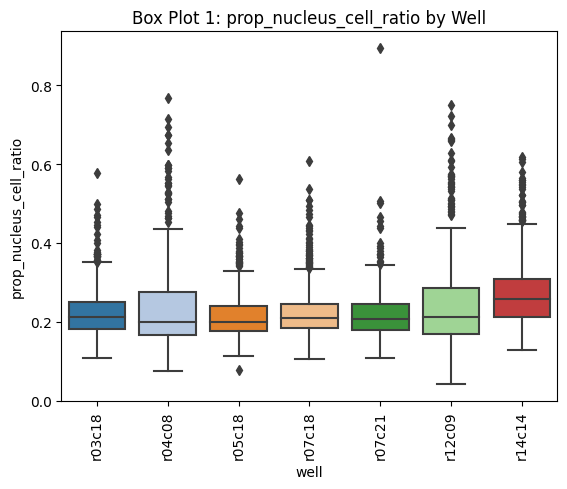

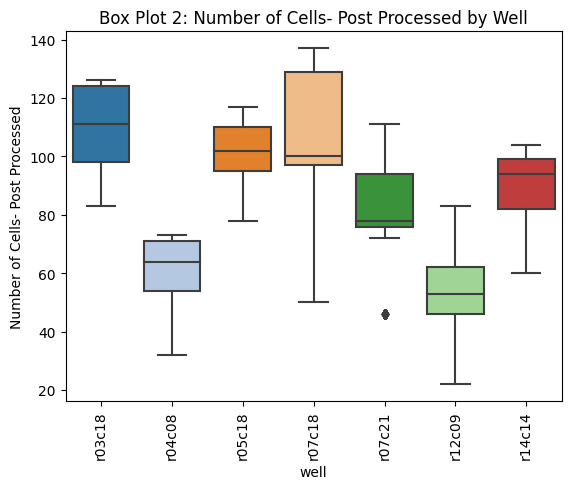

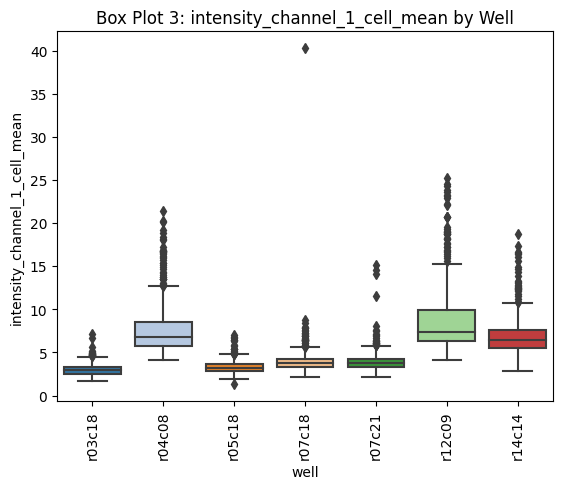

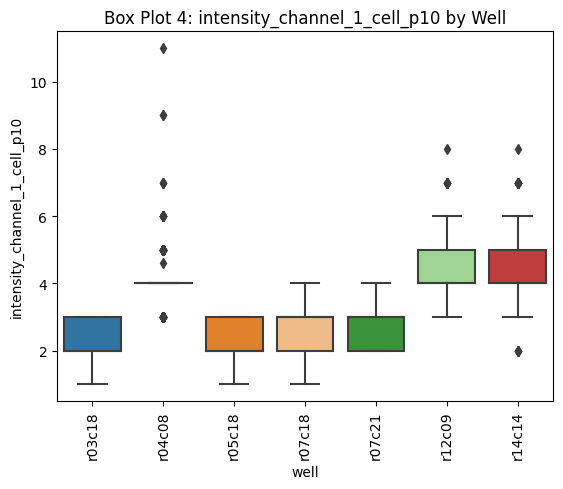

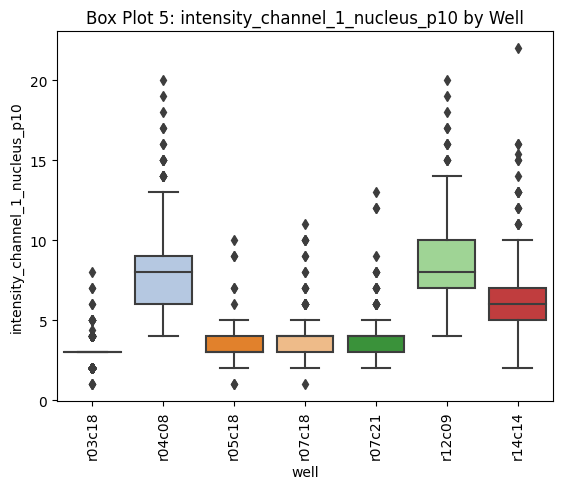

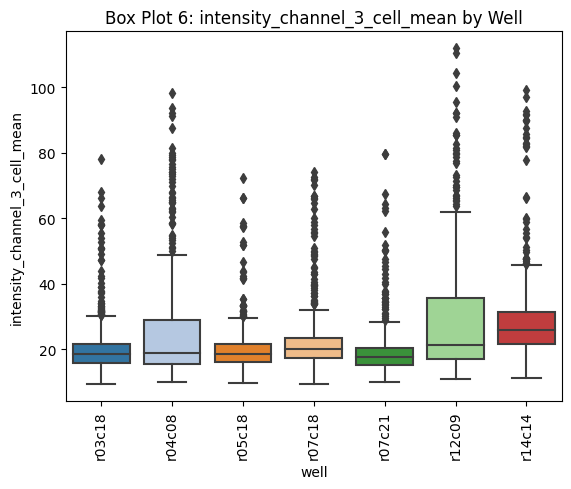

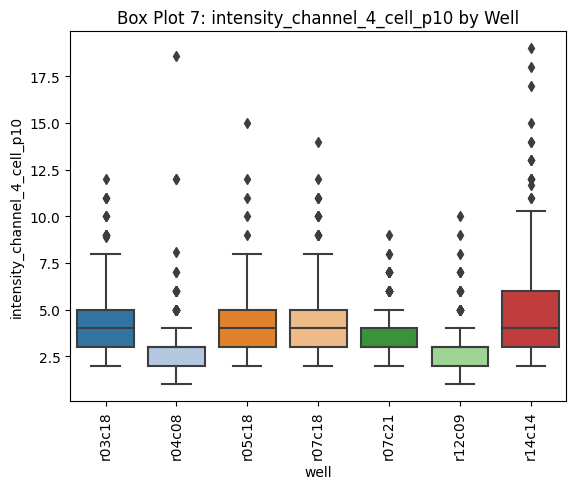

In [24]:
# Univariate analysis for 7 prominent features
single_features = ['prop_nucleus_cell_ratio', 'Number of Cells- Post Processed',
       'intensity_channel_1_cell_mean', 'intensity_channel_1_cell_p10',
       'intensity_channel_1_nucleus_p10', 'intensity_channel_3_cell_mean',
       'intensity_channel_4_cell_p10']


for idx, feature in enumerate(single_features, start=1):

    plt.figure()
    sns.boxplot(data= all_feat_combined, x='well', y=feature, palette='tab20')
    plt.title(f'Box Plot {idx}: {feature} by Well')
    plt.xticks(rotation=90)

    plt.show()



<Axes: >

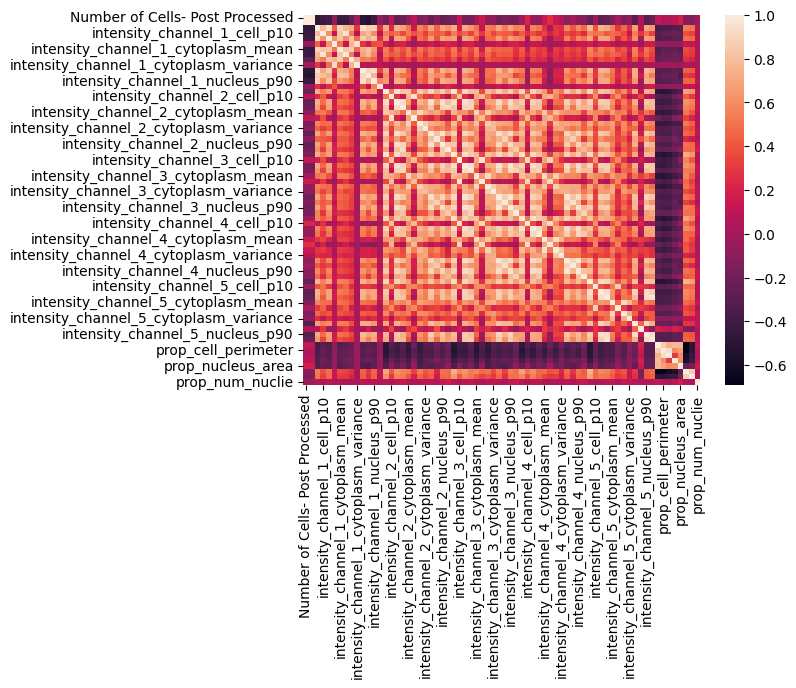

In [25]:

sns.heatmap(all_feat_combined[reqd_feats].corr())

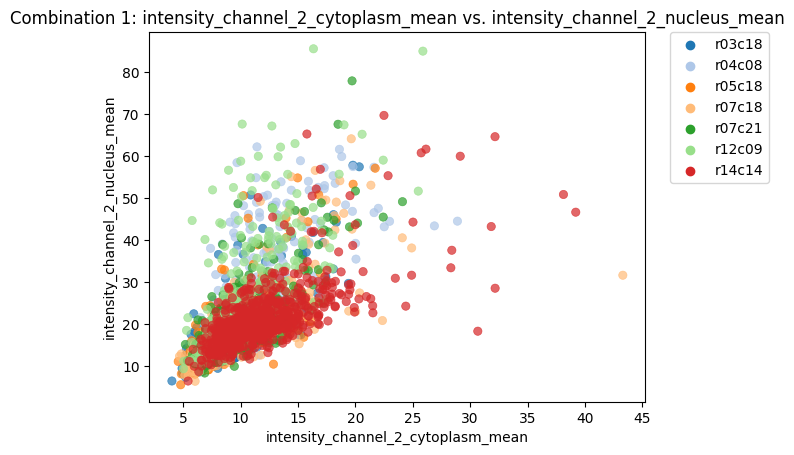

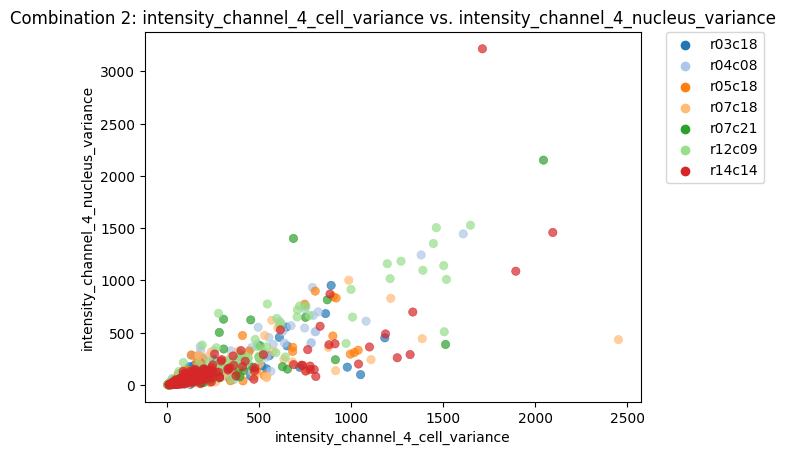

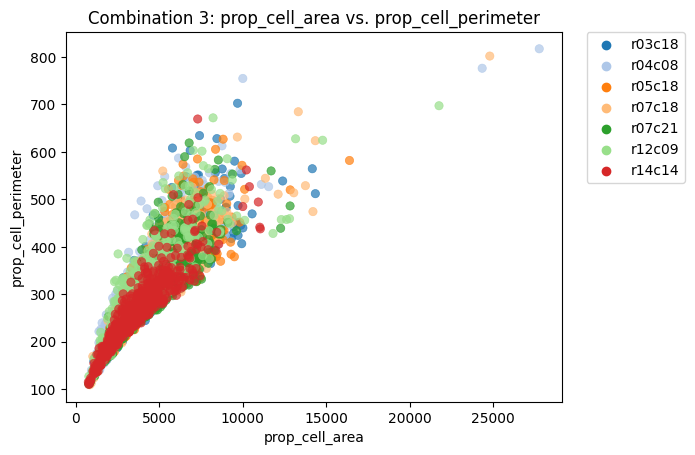

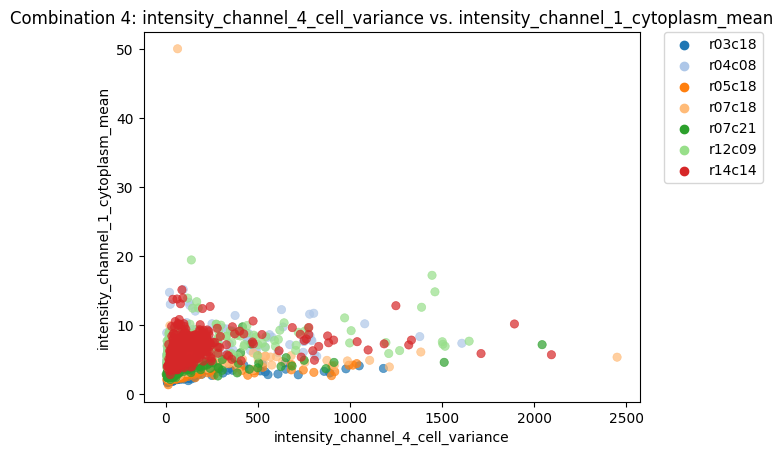

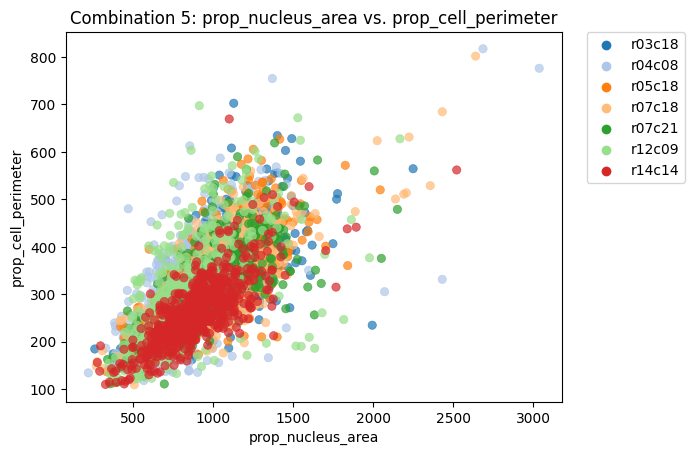

In [49]:
# BI-VARIATE ANALYSIS PLOTS

feature_combinations = [
  ('intensity_channel_2_cytoplasm_mean', 'intensity_channel_2_nucleus_mean'),
  ('intensity_channel_4_cell_variance', 'intensity_channel_4_nucleus_variance'),
  ('prop_cell_area', 'prop_cell_perimeter'),
  ('intensity_channel_4_cell_variance','intensity_channel_1_cytoplasm_mean'),
  ('prop_nucleus_area','prop_cell_perimeter')
]


for idx, (feature_x, feature_y) in enumerate(feature_combinations, start=1):
    plt.figure()
    sns.scatterplot(data= all_feat_combined, x=feature_x, y=feature_y, hue='well', palette='tab20', edgecolor=None, alpha=0.7)
    plt.title(f'Combination {idx}: {feature_x} vs. {feature_y}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

In [29]:
!pip install umap-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=5fd0c856ee9cb3d29a479d9df23bb8274e6048235f95102e78a56f213eef9295
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=0f3c1333b347cdf3aab0a334ecdb68dee1855d8808158a90ae98edcdbe73271f
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


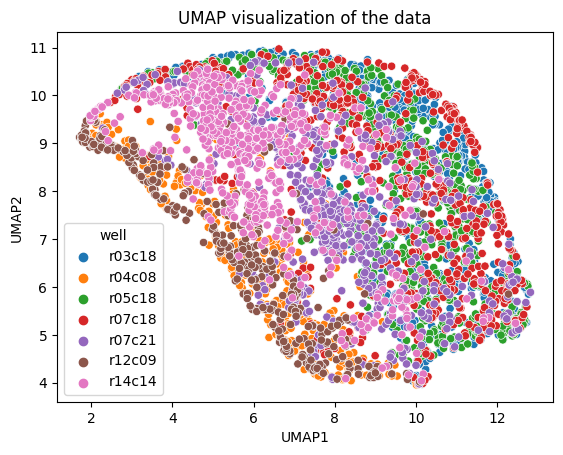

In [70]:
# DIMENSIONALITY REDUTION USING UMAP

data = all_feat_combined

features = ['prop_nucleus_cell_ratio', 'Number of Cells- Post Processed', 'intensity_channel_1_cell_mean', 'intensity_channel_2_cytoplasm_mean',
            'intensity_channel_3_cell_mean', 'intensity_channel_4_cell_mean', 'intensity_channel_5_nucleus_mean','prop_cell_perimeter', 
            'prop_major_axis_length','prop_minor_axis_length', 'prop_nucleus_area']

data_features = data[features]

scaler = StandardScaler()
data_features_standardized = scaler.fit_transform(data_features)


umap_transformer = umap.UMAP(random_state=42, n_neighbors = 30)

umap_results = umap_transformer.fit_transform(data_features_standardized)


data['UMAP1'] = umap_results[:, 0]
data['UMAP2'] = umap_results[:, 1]

sns.scatterplot(x='UMAP1', y='UMAP2', hue='well', data=data)
plt.title('UMAP visualization of the data')
plt.show()


In [72]:
all_feat_combined.to_csv(output_dir + '/jump_cell_painting_results.csv')